In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from scipy.stats import f_oneway
from scipy.stats import ttest_ind
from sklearn.model_selection import GridSearchCV

# 1,338 sample observations, one duplicate
# goal is to see if charges differ based on region 

In [90]:
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [92]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [93]:
# no missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [94]:
# one duplicate record
df[df.duplicated()]
df[(df["age"] == 19) & (df["sex"] == "male") & (df["bmi"] == 30.59) & (df["region"] == "northwest")]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [95]:
# get rid of duplicate value
df = df.drop_duplicates()
df.shape

(1337, 7)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


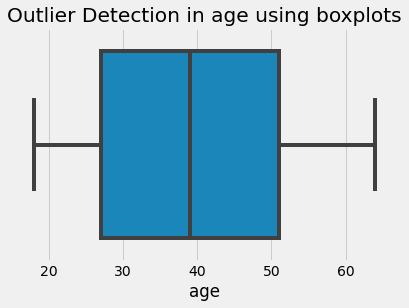

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


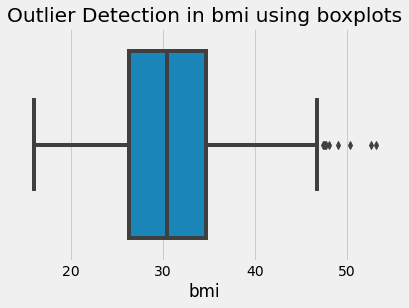

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


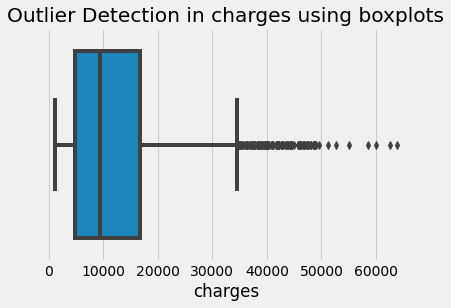

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


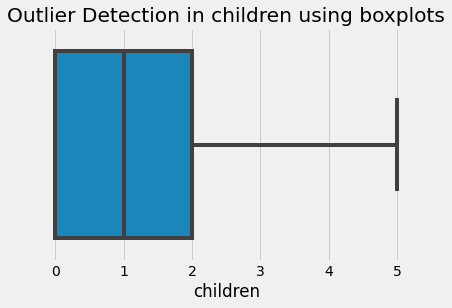

In [96]:
num_cols = ['age', 'bmi', 'charges', 'children']

for col in num_cols: 
    plt.style.use("fivethirtyeight")
    sns.boxplot(df[col])
    plt.title(f"Outlier Detection in {col} using boxplots")
    plt.show()


Interpreting the distribution box plots: 
- age seems to be normally distributed
- bmi has a few outliers, highest value being 53.13 (morbidly obese). I will not remove them because it makes sense given the decently large sample
- charges has a large amount of outliers, but these are often covered by insurance at least in part, so i'll leave them alone. 

In [97]:
# even split between regional data
max_bmi = df["bmi"].max()
unique_regions = df['region'].value_counts()
print(unique_regions)
print(f"largest value in BMI: {max_bmi}")

southeast    364
southwest    325
northwest    324
northeast    324
Name: region, dtype: int64
largest value in BMI: 53.13


In [98]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [99]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


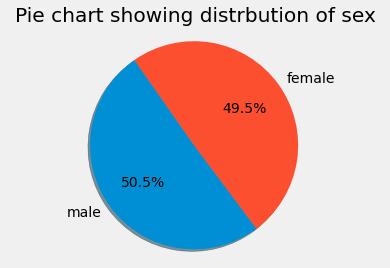

In [100]:
# quick EDA visualization 
# distribution of male/female
sex_dist = round(df['sex'].value_counts(normalize=True),3)*100

plt.pie(sex_dist.values, labels = sex_dist.index, 
        autopct='%1.1f%%', shadow = True, startangle=125)
plt.axis('equal')
plt.title('Pie chart showing distrbution of sex')
plt.show()

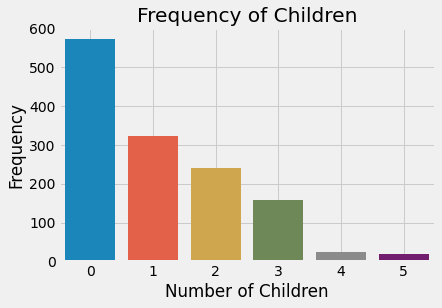

In [101]:
sns.countplot(x="children", data = df)
plt.title('Frequency of Children')
plt.xlabel('Number of Children')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


## majority (over half) of the samples have no children

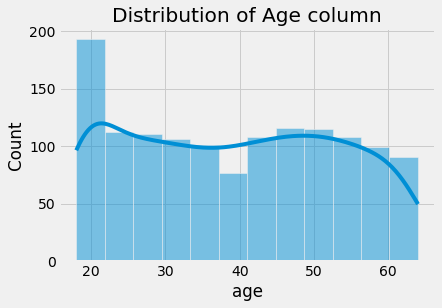

In [102]:
# looking into numerical distribution of the age column
sns.histplot(x="age", data = df, kde=True)
plt.title("Distribution of Age column")
plt.show()

## The majority of the data seems to fall into the 19-22 age range
- otherwise age is normally distributed. 

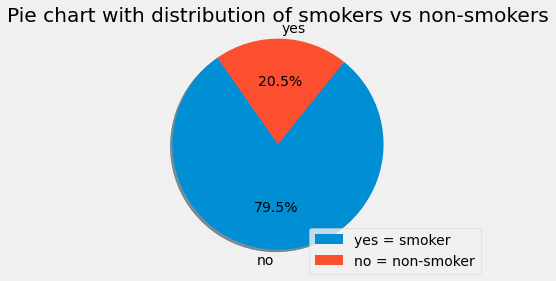

In [103]:
smoking = round(df['smoker'].value_counts(normalize=True)*100,3)

plt.pie(smoking.values, labels = smoking.index, 
        autopct='%1.1f%%', shadow=True, startangle=125)

plt.title('Pie chart with distribution of smokers vs non-smokers')
plt.axis('equal')
plt.legend(["yes = smoker", "no = non-smoker"], bbox_to_anchor=(1,0), loc="lower right", 
            bbox_transform = plt.gcf().transFigure)
plt.show() 

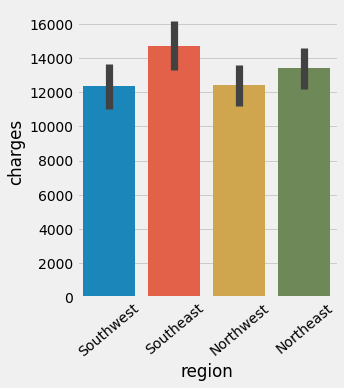

In [104]:
# charges are highest in SE region, makes sense because it's the largest portion of the data
g = sns.catplot(
    data=df, x="region", y="charges",
    kind="bar",
)
g.set_xticklabels(labels = ["Southwest", "Southeast", "Northwest", "Northeast"], rotation = 40)
plt.show()



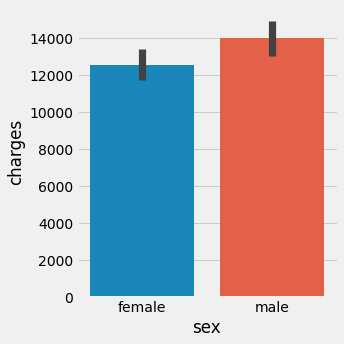

In [105]:
#males tend to have a higher charge
sns.catplot(
    data=df, x="sex", y="charges",
    kind="bar"
)


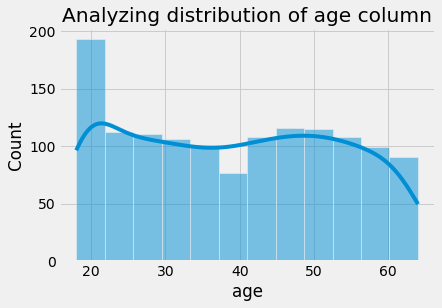

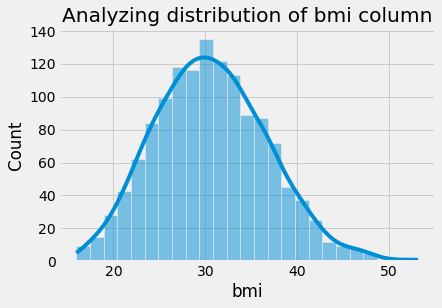

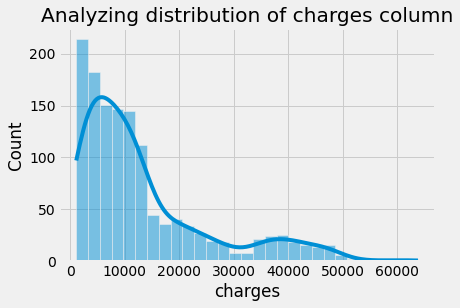

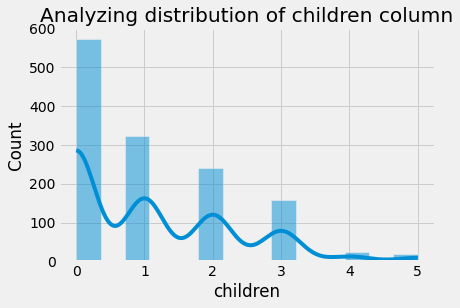

In [106]:
# using histogram to check distrbution of numeric variables
for col in num_cols: 
    sns.histplot(x = col, data = df, kde = True)
    plt.title(f"Analyzing distribution of {col} column")
    plt.show()

## interpretation of numeric columns
- age is almost uniform with heavy emphasis on 19-22 years old. 
- bmi is almost a perfect normal distribution, slightly right skewed
- charges are exponentially distributed, heavily right skewed

# Sex and Charges

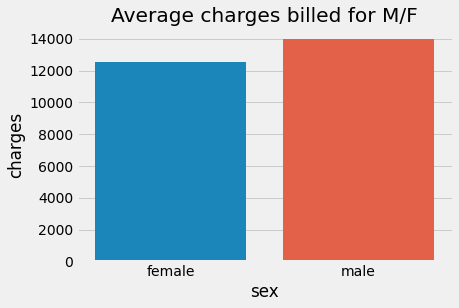

In [107]:
sns.barplot(x="sex", y="charges", data = df, ci=False)
plt.title("Average charges billed for M/F")
plt.show()

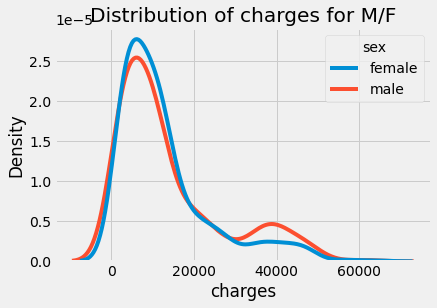

In [108]:
sns.kdeplot(x="charges",data=df,hue="sex")
plt.title("Distribution of charges for M/F")
plt.show()

- This plot suggests there is a difference in charges between the groups. We can apply a t-test to find whether or not this is statistically significant

## Testing whether these independent samples are significantly different: 
- H0 : The charges for M/F are equal
- H1 : The charges for M/F are not equal

In [109]:
males = df[df["sex"] == "male"]["charges"]
females = df[df["sex"] == "female"]["charges"]

stat,p = ttest_ind(males,females)
if p > 0.05:
    print(f"P-value is {p}")
    print("We cannot reject the null hypothesis, there is no diference in average charges billed for male and female")
else:
    print(f"P-value is {p}")
    print("We can reject the null hypothesis, there is a diference in average charges billed for male and female")

P-value is 0.0338207919951195
We can reject the null hypothesis, there is a diference in average charges billed for male and female


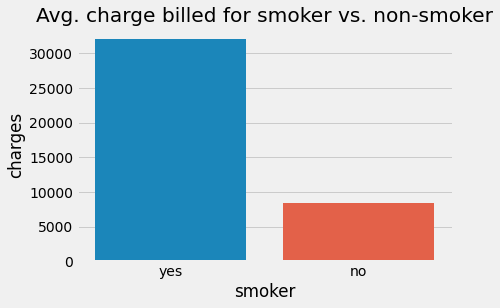

In [110]:
# charges for smokers
sns.barplot(x="smoker",y="charges", data=df, ci=False)
plt.title("Avg. charge billed for smoker vs. non-smoker")
plt.show()

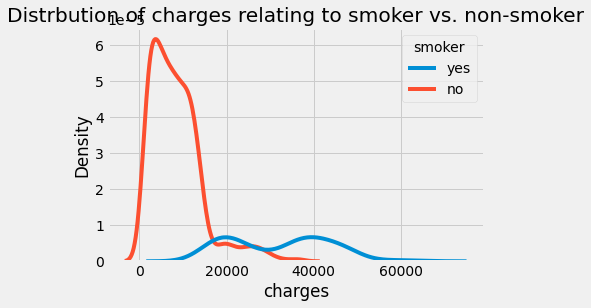

In [111]:
sns.kdeplot(x="charges", data=df, hue="smoker")
plt.title("Distrbution of charges relating to smoker vs. non-smoker")
plt.show()

# the KDE plot above shows there is a large difference between the groups
- lets conduct another one sided t-test to see if there is a difference between smoker/non-smoker

Interpretation
H0 : The means of the two sample (charges for smoker and non-smoker) are equal. The average billed charges for smoker is not greater than the non-smoker.
H1 : The mean of billed charges for smokers is greater than the averag charges billed for non-smokers.

Applying one sided (greater) t-test.

In [112]:
smokers_charged = df[df["smoker"] == "yes"]["charges"]
non_smokers_charged = df[df["smoker"] == "no"]["charges"]

stat,p = ttest_ind(smokers_charged,non_smokers_charged,alternative="greater")
if p > 0.05:
    print(f"P-value is {p}")
    print("We cannot reject the null hypothesis, the average billing for smoker is not greater than the non-smoker")
else:
    print(f"P-value is {p}")
    print("We can reject the null hypothesis, the average billing for smoker is greater than the non-smoker")

P-value is 7.033610474688249e-283
We can reject the null hypothesis, the average billing for smoker is greater than the non-smoker


In [113]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

## ANOVA Testing for different groups

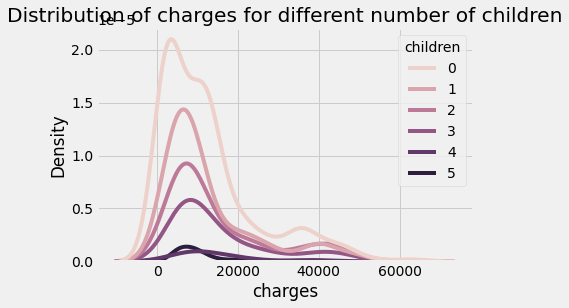

In [114]:
sns.kdeplot(x="charges",data=df, hue="children")
plt.title("Distribution of charges for different number of children")
plt.show()

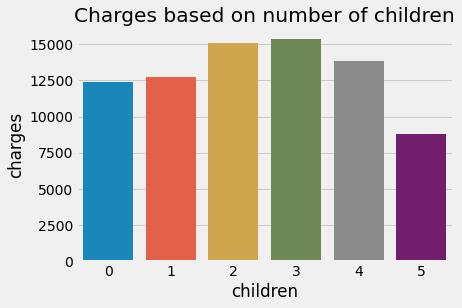

In [115]:
sns.barplot(x="children", y="charges", data = df,ci=False)
plt.title("Charges based on number of children")
plt.show()

## Based on the plots above we can tell there is a difference between the groups
- lets conudct a one-way ANOVA to estimate the significance of the difference. 

Interpretation: 
- H0: sample means are equivalent
- H1: sample means are not equivalent


In [116]:
# splitting into groups with respective charges
no_children = df[df["children"] == 0]["charges"]
one_children = df[df["children"] == 1]["charges"]
two_children = df[df["children"] == 2]["charges"]
three_children = df[df["children"] == 3]["charges"]
four_children = df[df["children"] == 4]["charges"]
five_children = df[df["children"] == 5]["charges"]

stat,p = f_oneway(no_children,one_children,two_children,three_children,four_children,five_children)
if p > 0.05:
    print("We cannot reject the null hypothesis. The average billing  is not different for all samples")
else:
    print("We can reject the null hypothesis. The average billing is different for samples")

We can reject the null hypothesis. The average billing is different for samples


## looking at distribution of charges for different locations

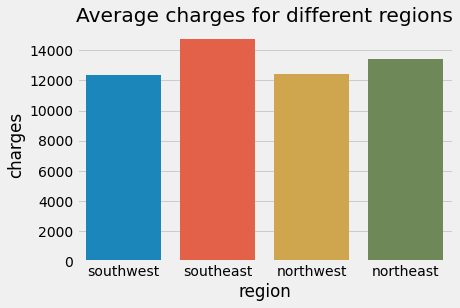

In [117]:
sns.barplot(x="region", y="charges", data=df, ci=False)
plt.title("Average charges for different regions")
plt.show()

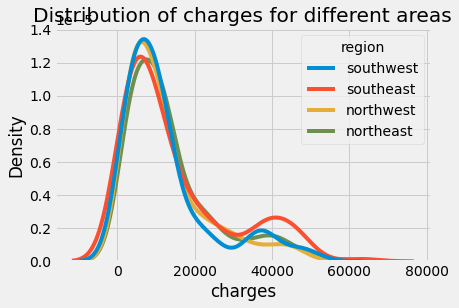

In [118]:
sns.kdeplot(x="charges",hue="region",data=df)
plt.title("Distribution of charges for different areas")
plt.show()

## based on the dist plot and bar plot above, it seems there is a difference between regions and charges
- lets conduct another one-way ANOVA test to see if it's significant

interpretation: 
- H0: average charges for different regions is equivalent
- H1: average charges for different regions are not equivalent


In [119]:
# splitting into groups with respective charges
southeast = df[df["region"] == "southeast"]["charges"]
southwest = df[df["region"] == "southwest"]["charges"]
northeast = df[df["region"] == "northeast"]["charges"]
northwest = df[df["region"] == "northwest"]["charges"]

stat,p = f_oneway(no_children,one_children,two_children,three_children,four_children,five_children)
if p > 0.05:
    print("We cannot reject the null hypothesis. The average billing  is not different for all samples")
else:
    print("We can reject the null hypothesis. The average billing is different for samples")

We can reject the null hypothesis. The average billing is different for samples


## Let's try to predict the charge amount using a few ML models
- models used: linear regression, lass/ridge regression, decision tree, randomforest

In [120]:
# we need to preprocess the object (str) columns to be numerical
df.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [121]:
# converting sex, region, smoker
df2 = df.copy()

df2["sex"] = df2["sex"].replace("male",1)
df2["sex"] = df2["sex"].replace("female",0)

df2["region"] = df2["region"].replace("southwest",0)
df2["region"] = df2["region"].replace("southeast",1)
df2["region"] = df2["region"].replace("northwest",2)
df2["region"] = df2["region"].replace("northeast",3)

df2["smoker"] = df2["smoker"].replace("yes",1)
df2["smoker"] = df2["smoker"].replace("no",0)

In [122]:
# looks like preprocessing worked, we now only have numerical columns
df2.dtypes

age           int64
sex           int64
bmi         float64
children      int64
smoker        int64
region        int64
charges     float64
dtype: object

In [135]:
X = df2.copy()
X.drop("charges", axis=1, inplace = True)
y = df2["charges"]


,age,sex,bmi,children,smoker,region
0,19,0,27.900,0,1,0
1,18,1,33.770,1,0,1
2,28,1,33.000,3,0,1
3,33,1,22.705,0,0,2
4,32,1,28.880,0,0,2


In [168]:
#Normalize the columns: 'age','bmi', 'children', 'region'" 
cols_to_norm = ['age','bmi', 'children', 'region']
X[cols_to_norm] = X[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

X.head()

,age,sex,bmi,children,smoker,region
0,0.021739,0,0.321227,0.0,1,0.000000
1,0.000000,1,0.479150,0.2,0,0.333333
2,0.217391,1,0.458434,0.6,0,0.333333
3,0.326087,1,0.181464,0.0,0,0.666667
4,0.304348,1,0.347592,0.0,0,0.666667


In [171]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=4)

In [172]:
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}, y_train: {y_train.shape}, y_test: {y_test.shape}")

X_train: (935, 6), X_test: (402, 6), y_train: (935,), y_test: (402,)


## To Do
- inverse_transfrom after model is ran on test
- GridSearch tune hyper params for best model - models evaluated: Linear, Lasso, Ridge, Decision Tree, Random Forest
- if best model is a tree type use tree visualizer

In [173]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor